## Demo Notebook for Accessing Sup3rcc Data on Azure

The Super-Resolution for Renewable Energy Resource Data with Climate Change Impacts (Sup3rCC) data is a collection of 4km hourly wind, solar, temperature, humidity, and pressure fields for the contiguous United States under climate change scenarios.

Sup3rCC is downscaled Global Climate Model (GCM) data. For example, the initial dataset "sup3rcc_conus_mriesm20_ssp585_r1i1p1f1" is downscaled from MRI ESM 2.0 for climate change scenario SSP5 8.5 and variant label r1i1p1f1. The downscaling process was performed using a generative machine learning approach called sup3r: Super-Resolution for Renewable Energy Resource Data (linked below as "Sup3r GitHub Repo"). The data includes both historical and future weather years, although the historical years represent the historical average climate, not the actual historical weather that we experienced.

The Sup3rCC data is intended to help researchers study the impact of climate change on energy systems with high levels of wind and solar capacity. Please note that all climate change data is only a representation of the *possible* future climate and contains significant uncertainty. Analysis of multiple climate change scenarios and multiple climate models can help quantify this uncertainty.

For more information about Sup3rcc, please refer to its OEDI catalogue entry: https://data.openei.org/submissions/5839

This notebook will demonstrate how to access the Sup3rcc data located in Azure BLOB storage using kerchunk.

### Requirements

In order to run this notebook, please ensure you have the following packages installed:

matplotlib==3.7.1  
numpy==1.24.3  
planetary_computer==0.5.1  
scipy==1.10.1  
ujson==5.7.0  
xarray==2023.4.2  

### Load kerchunk Reference File

You do not need an Azure account to access public data. Instead, you can use the planetary-computer library to obain temporary credentials, as shown below. To access Supe3rcc, we need to load the kerchunk reference file, which is stored in the same container as the rest of the data. Depending on your network, this step may take several minutes as the reference file is a few hundred MB.

In [1]:
import planetary_computer
import ujson

fs = planetary_computer.get_adlfs_filesystem('nrel', 'oedi')
with fs.open('oedi/sup3rcc/conus_mriesm20_ssp585_r1i1p1f1/kerchunk_reference.json', 'rb') as ref_file:
    ref = ujson.load(ref_file)

### Create xarray dataset

Next we use the xarray package to read the reference file and give us an interface to access the dataset.

In [2]:
import xarray as xr

token = planetary_computer.sas.get_token('nrel', 'oedi').token
ds = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": ref,
            "remote_protocol": "abfs",
            "remote_options": {'account_name': 'nrel', "credential": token}
        },
        "consolidated": False,
    }
)
ds

<xarray.Dataset>
Dimensions:              (latitude: 650, longitude: 1475, time_index: 175320)
Coordinates:
  * latitude             (latitude) float32 51.57 51.52 51.48 ... 22.5 22.45
  * longitude            (longitude) float32 -129.9 -129.9 ... -63.63 -63.58
  * time_index           (time_index) datetime64[ns] 2015-01-01 ... 2059-12-3...
Data variables: (12/19)
    country              (latitude, longitude) object ...
    county               (latitude, longitude) object ...
    dhi                  (time_index, latitude, longitude) float32 ...
    dni                  (time_index, latitude, longitude) float32 ...
    eez                  (latitude, longitude) float32 ...
    elevation            (latitude, longitude) float32 ...
    ...                   ...
    winddirection_100m   (time_index, latitude, longitude) float32 ...
    winddirection_10m    (time_index, latitude, longitude) float32 ...
    winddirection_200m   (time_index, latitude, longitude) float32 ...
    windspeed_100m       (time_index, latitude, longitude) float32 ...
    windspeed_10m        (time_index, latitude, longitude) float32 ...
    windspeed_200m       (time_index, latitude, longitude) float32 ...
Attributes:
    full_version_record:  {"rex": "0.2.77", "pandas": "1.3.5", "numpy": "1.19...
    gan_meta:             [{"temp_lapse_rate": 0.0065, "s_enhance": 25, "t_en...
    input_features:       ["pressure_0m"]
    input_files:          ["/scratch/gbuster/sup3r/source_gcm_data/pressure_d...
    model_class:          MultiStepSurfaceMetGan
    model_kwargs:         {"temporal_model_kwargs": {"model_dir": "/projects/...
    output_features:      ["pressure_0m"]
    package:              sup3r
    spatial_enhance:      25
    temporal_enhance:     24
    version:              0.0.9

### Import Data

The sel() and isel() methods make it easy to select the data that you want. We will select some data and then load the results into pandas dataframes.

Here we load data from the 2015 and the 2050 files. Note that:

1. The 2015 year does not represent the actual historical weather in 2015, just the historical climate in 2015
2. Comparing single years is imprecise because normal variability in the climate can skew the results, we use single years here just for illustrative purposes

In [3]:
# Coordinates for NREL campus
coords = {
    'latitude': 39.741,
    'longitude': -105.171
 }

# Select the point in the dataset that is nearest to NRELs campus
ds_nrel = ds.sel(**coords, method='nearest')

# Take time slices for 2015 and 2050
ds_nrel_2015 = ds_nrel.sel(time_index = slice('2015-01-01', '2015-12-31'))
ds_nrel_2050 = ds_nrel.sel(time_index = slice('2050-01-01', '2050-12-31'))

# Identify variables
vars = ['ghi', 'windspeed_100m', 'temperature_2m']

# Note that no data has actually been loaded yet! Next, we load the data into pandas dataframes
data_2015 = ds_nrel_2015[vars].to_dataframe()[vars]
data_2050 = ds_nrel_2050[vars].to_dataframe()[vars]

# Rename columns for convenience
data_2015 = data_2015.rename(columns={'windspeed_100m': 'ws', 'temperature_2m': 'temp'})
data_2050 = data_2050.rename(columns={'windspeed_100m': 'ws', 'temperature_2m': 'temp'})

# Fill na in ghi with 0
data_2015 = data_2015.fillna({'ghi': 0})
data_2050 = data_2050.fillna({'ghi': 0})

### Comparing Differences in Temperature

Here, we can see that 2050 has an increase in average dry bulb temperature versus 2015, as well as more extreme hot and cold events.

2015 Summary
               ghi           ws         temp
count  8760.000000  8760.000000  8758.000000
mean    209.282654     3.378573     8.702493
std     286.178650     2.151689    10.412784
min       0.000000     0.010000   -19.379999
25%       0.000000     1.860000     0.380000
50%       0.000000     2.920000     7.610000
75%     402.000000     4.390000    16.850000
max    1023.000000    16.480000    34.540001
2050 Summary
               ghi           ws         temp
count  8760.000000  8760.000000  8758.000000
mean    221.332199     3.564847     9.956614
std     296.225220     2.364556    12.077272
min       0.000000     0.010000   -25.789999
25%       0.000000     1.860000     0.630000
50%       0.000000     3.020000     9.220000
75%     439.000000     4.680000    19.449999
max    1036.000000    15.250000    38.079998


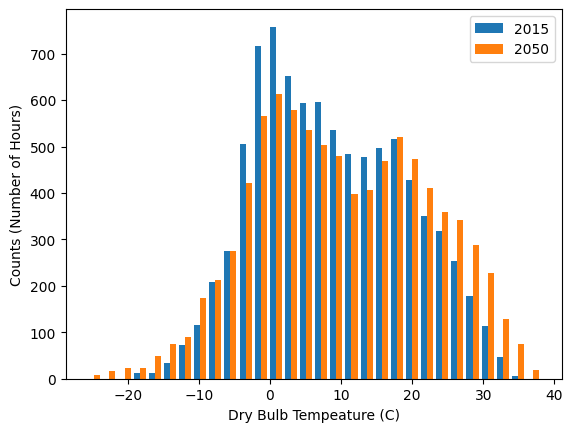

In [4]:
import matplotlib.pyplot as plt

print('2015 Summary')
print(data_2015.describe())

print('2050 Summary')
print(data_2050.describe())

plt.hist([data_2015['temp'], data_2050['temp']], bins=30)
plt.xlabel('Dry Bulb Tempeature (C)')
plt.ylabel('Counts (Number of Hours)')
plt.legend(['2015', '2050'])

### Wind and Solar Resource

You can use joint probability distributions to visualize the distribution of syncronous wind and solar resources. In practice, you would want to use a tool like the System Advisor Model (SAM) or the Renewable Energy Potential Model (reV) to convert these meteorological variables into potential power generation.

Text(0, 0.5, '2050 Hourly Windspeed (m/s)')

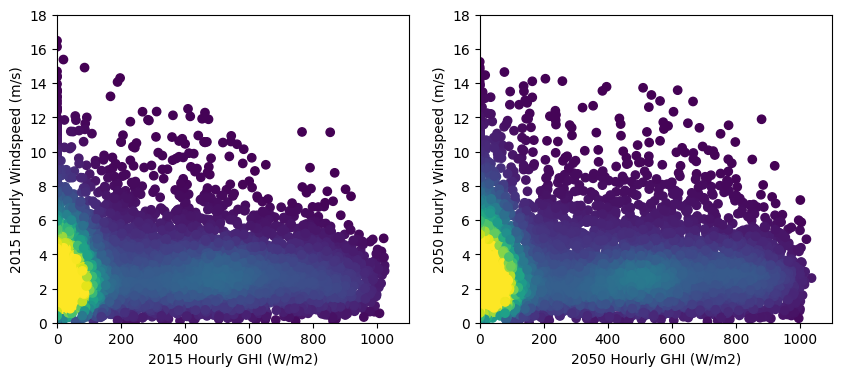

In [5]:
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_density(x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / (z.max() - z.min())
    return z

c1 = get_density(data_2015['ghi'], data_2015['ws'])
c2 = get_density(data_2050['ghi'], data_2050['ws'])

ax[0].scatter(data_2015['ghi'], data_2015['ws'], c=c1, vmin=0, vmax=0.5)
ax[1].scatter(data_2050['ghi'], data_2050['ws'], c=c2, vmin=0, vmax=0.5)

for subax in ax:
    subax.set_xlim(0, 1100)
    subax.set_ylim(0, 18)
    
ax[0].set_xlabel('2015 Hourly GHI (W/m2)')
ax[0].set_ylabel('2015 Hourly Windspeed (m/s)')
ax[1].set_xlabel('2050 Hourly GHI (W/m2)')
ax[1].set_ylabel('2050 Hourly Windspeed (m/s)')

Text(0, 0.5, '2050 Daily Average Windspeed (m/s)')

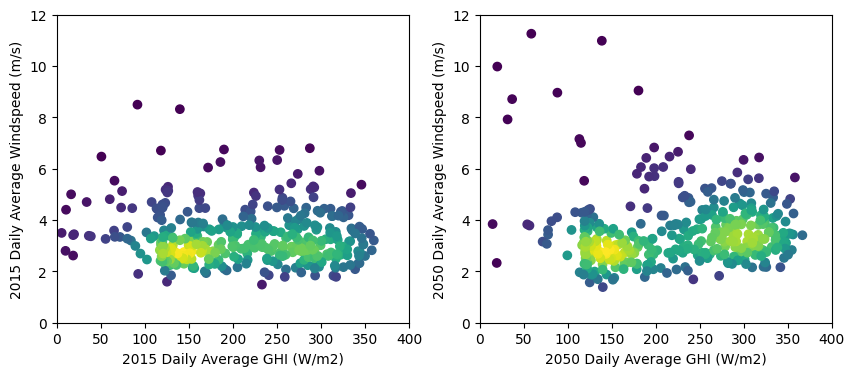

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_daily_means(arr):
    arr = np.roll(arr, -7)
    day_slices = [slice(i, i+24) for i in range(0, 8760, 24)]
    arr = [arr[islice].mean() for islice in day_slices]
    return np.array(arr)

ghi_2015 = get_daily_means(data_2015['ghi'])
ghi_2050 = get_daily_means(data_2050['ghi'])
ws_2015 = get_daily_means(data_2015['ws'])
ws_2050 = get_daily_means(data_2050['ws'])

c1 = get_density(ghi_2015, ws_2015)
c2 = get_density(ghi_2050, ws_2050)

ax[0].scatter(ghi_2015, ws_2015, c=c1, vmin=0, vmax=1)
ax[1].scatter(ghi_2050, ws_2050, c=c2, vmin=0, vmax=1)

for subax in ax:
    subax.set_xlim(0, 400)
    subax.set_ylim(0, 12)
    
ax[0].set_xlabel('2015 Daily Average GHI (W/m2)')
ax[0].set_ylabel('2015 Daily Average Windspeed (m/s)')
ax[1].set_xlabel('2050 Daily Average GHI (W/m2)')
ax[1].set_ylabel('2050 Daily Average Windspeed (m/s)')

Text(0, 0.5, '2050 Daily Average Windspeed (m/s)')

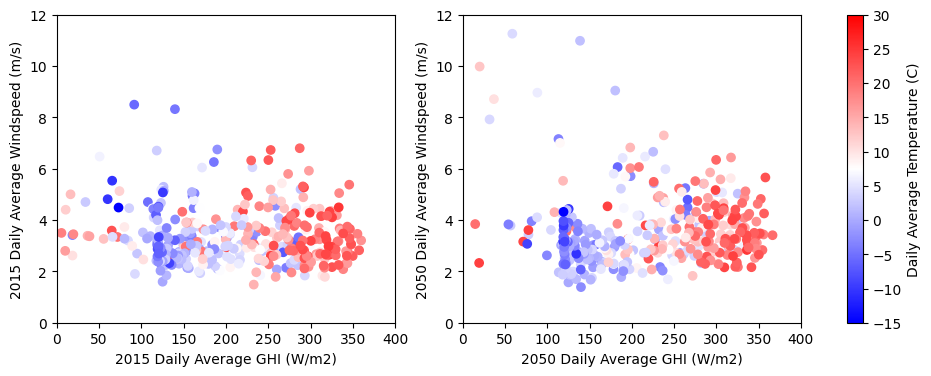

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

def get_daily_means(arr):
    arr = np.roll(arr, -7)
    day_slices = [slice(i, i+24) for i in range(0, 8760, 24)]
    arr = [arr[islice].mean() for islice in day_slices]
    return np.array(arr)

ghi_2015 = get_daily_means(data_2015['ghi'])
ghi_2050 = get_daily_means(data_2050['ghi'])
ws_2015 = get_daily_means(data_2015['ws'])
ws_2050 = get_daily_means(data_2050['ws'])
temp_2015 = get_daily_means(data_2015['temp'])
temp_2050 = get_daily_means(data_2050['temp'])

a = ax[0].scatter(ghi_2015, ws_2015, c=temp_2015, vmin=-15, vmax=30, cmap='bwr')
b = ax[1].scatter(ghi_2050, ws_2050, c=temp_2015, vmin=-15, vmax=30, cmap='bwr')
plt.colorbar(b, ax=ax, label='Daily Average Temperature (C)')

for subax in ax:
    subax.set_xlim(0, 400)
    subax.set_ylim(0, 12)
    
ax[0].set_xlabel('2015 Daily Average GHI (W/m2)')
ax[0].set_ylabel('2015 Daily Average Windspeed (m/s)')
ax[1].set_xlabel('2050 Daily Average GHI (W/m2)')
ax[1].set_ylabel('2050 Daily Average Windspeed (m/s)')